In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.integrate import solve_bvp, solve_ivp
from scipy.optimize import root

%run simulation
%run control
%run plotting

#from simulation import *
#from control import *
#from plotting import *

plt.style.use("dark_background")

In [2]:
def solar_sys_sol(x0, v0, masses, target, m0, t_guess=1, plot_initial=False, verbose=2):
    # Set up initial conditions and parameters
    t0 = 0
    tf = 5
    init = np.array([-.09, 0, 0, # Position 1
                     1, 0, 0, # Position 2
                     x0[0], x0[1], 0, # Position 3
                     0, -.09, 0, # Velocity/Momentum 1
                     0, 1, 0, # Velocity/Momentum 2
                     v0[0], v0[1], 0]) # Velocity 3 

    # Solve the system
    f = lambda t, y: gravity_acceleration_general(y, m=masses)
    sol = solve_ivp(f, (t0, tf), init, t_eval= np.linspace(t0, tf, 1000), dense_output=True)
    
    # Plot if requested
    if plot_initial:
        #Plot the initial system
        pos_guess = sol.sol(t_guess)[6:8]
        print(f"t_guess = {t_guess}, Position: {pos_guess}")

        ax = plt.gca()
        plt.scatter(*pos_guess, color="C2", marker='o', label="Position at t_guess", zorder=5)
        plt.scatter(*target, color="magenta", marker='o', label="Target", zorder=6)
        plot_nbody(sol.y, "Guess with no control", ax=ax)
        plt.show()
        
    sol2, u = solve_optimal_euclidean(sol, masses[:-1], x0, v0, m0, target, delta=1000, 
                                      tf_guess=t_guess, p12_guess_strat="bolza", 
                                      verbose=verbose, max_nodes=20_000)
    return sol, sol2, u

def plot_solar_sys_sol(sol, sol2, target, filename=None):
    print("t_f =", sol2.p[0])
    print("m_f =", sol2.y[4,-1])
    print("x(t_f) = ", sol2.y[:2, -1])

    fig, axs = plt.subplots(2,1, figsize=(8, 12))
    ax1, ax2 = axs

    ax1.plot(sol2.y[0], sol2.y[1], zorder=10, label="Controlled Body")
#     ax1.scatter(*pos_guess, color="C2", marker='o', label="Position at t_guess", zorder=5)
    ax1.scatter(*targ, color="lightsalmon", marker='o', label="Target", zorder=6)
    plot_nbody(sol.y, "Optimal Control solution", ax=ax1, plot_third=False)

    #Plot optimal control over time
    u1, u2 = u
    t  = sol2.p[0]*sol2.x
    ax2.plot(t, u1, c='C3', label="$u_1(t)$")
    ax2.plot(t, u2, c='C5', label="$u_2(t)$")
    ax2.plot(t, sol2.y[4], c='C4', label="$m(t)$")
    ax2.set_xlabel("t")
    ax2.set_ylabel("u")
    ax2.legend()
    ax2.grid() #remove grid
    ax2.set_title("Optimal control and mass", fontsize=16)

    plt.tight_layout()
    if filename is not None:
        plt.savefig(filename)
    plt.show()

t_guess = 2, Position: [0.22631237 2.85722818]


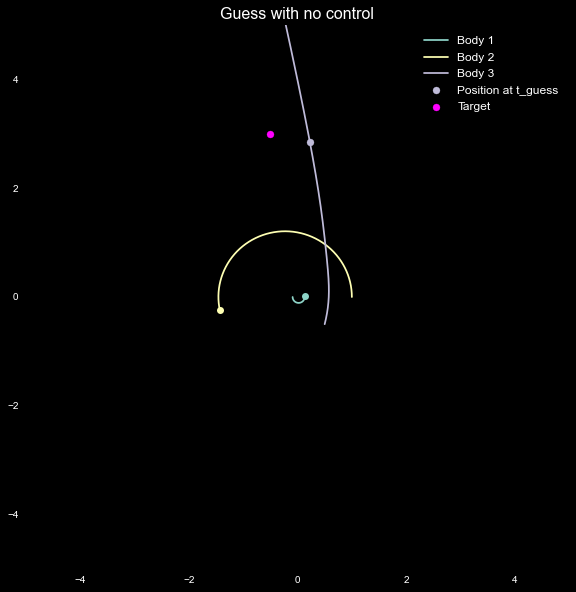

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.91e+02       3.85e+01          100            198      
       2          5.61e-04       1.20e-06          298             0       
Solved in 2 iterations, number of nodes 298. 
Maximum relative residual: 5.61e-04 
Maximum boundary residual: 1.20e-06
t_f = 2.2168959993891977
m_f = 4.307027654546444
x(t_f) =  [-0.47841337  3.01332287]


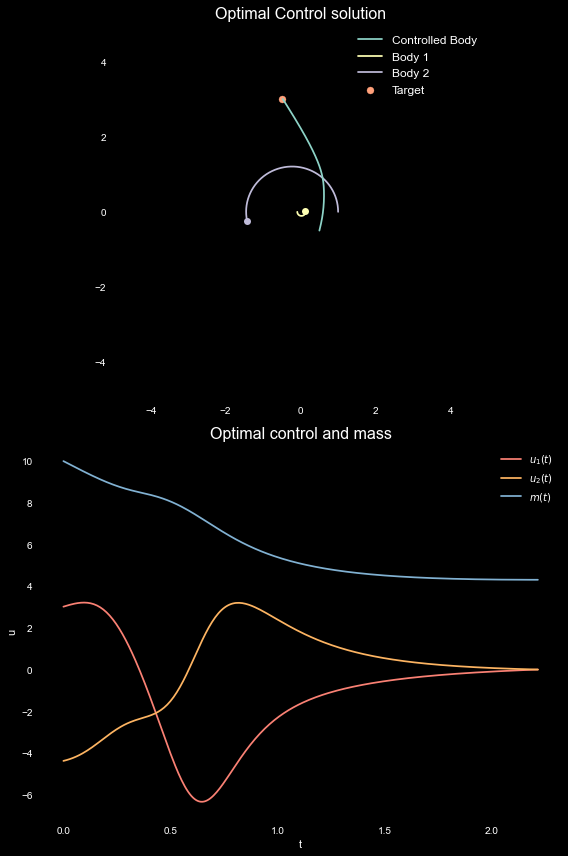

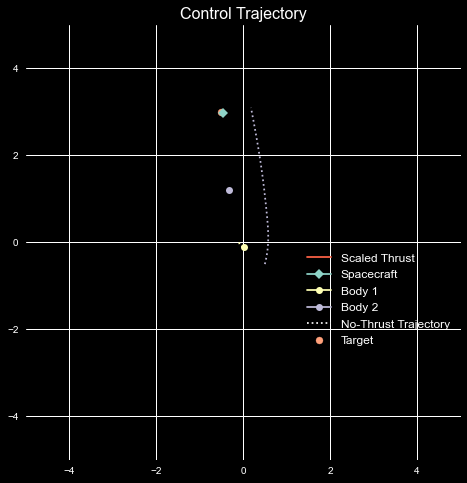

In [3]:
targ = np.array([-.5, 3])
sol, sol2, u = solar_sys_sol(x0=np.array([.5, -.5]), 
                        v0=np.array([.5, 2]), 
                        masses=np.array([1, .09, 0]), 
                        target=targ, 
                        m0=np.array([10]), 
                        t_guess=2, 
                        plot_initial=True,
                        verbose=2)

plot_solar_sys_sol(sol, sol2, targ, filename='./../Plots/initial_control_attempt')
animate_control(sol, sol2, u, targ, 'Control Trajectory', '/../Animations/initial_control_attempt', skip=5, interval=100., lim=(-5,5))

<video src="./../Animations/initial_control_attempt.mp4" controls></video>

t_guess = 2.5, Position: [-4.17688387  1.06832697]


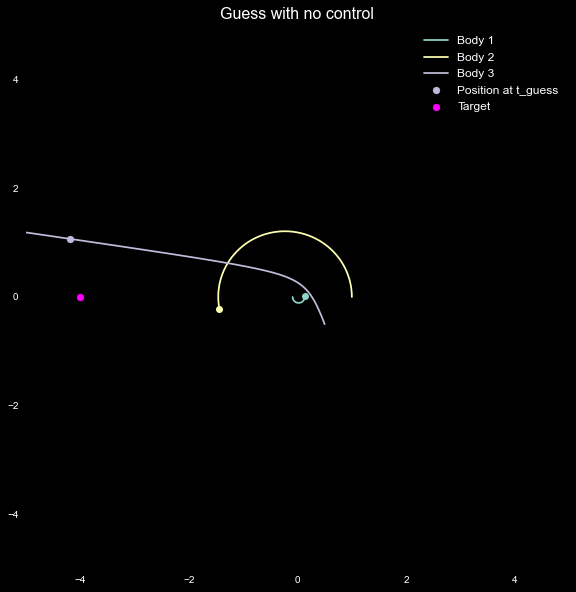

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          5.69e+01       5.96e+02          100            198      
       2          3.60e+02       2.14e+02          298            594      
       3          2.80e+02       3.93e+00          892           1716      
       4          5.00e-02       1.81e-04         2608            100      
       5          5.12e-06       5.16e-12         2708             0       
Solved in 5 iterations, number of nodes 2708. 
Maximum relative residual: 5.12e-06 
Maximum boundary residual: 5.16e-12
t_f = 2.5072023065822866
m_f = 8.306445176701102
x(t_f) =  [-3.99935723e+00 -2.72348681e-03]


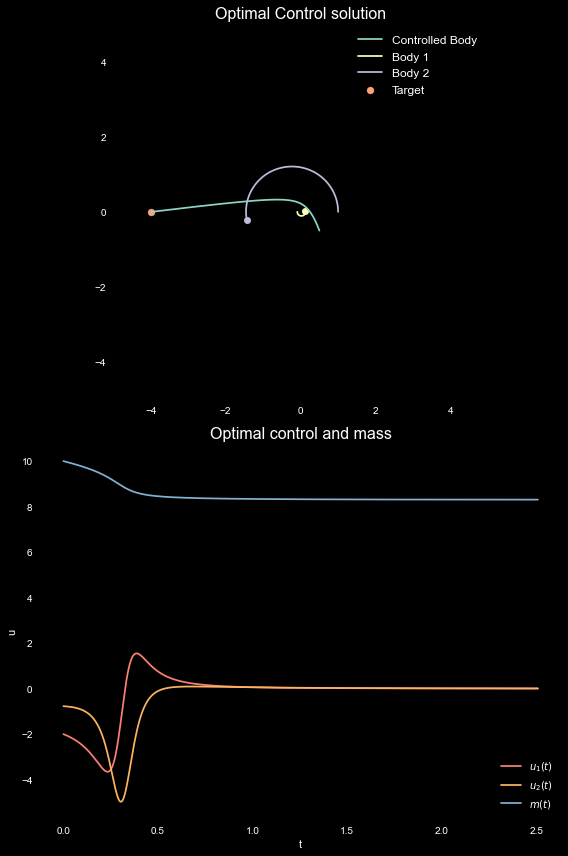

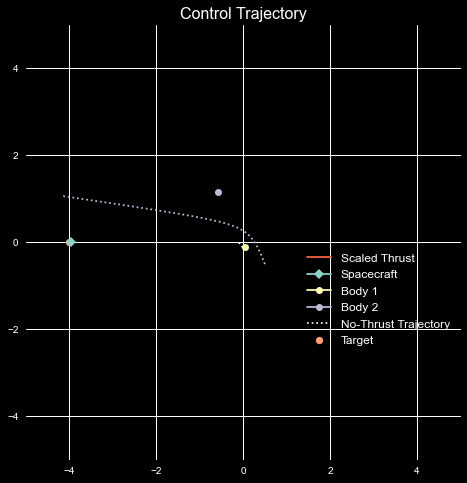

In [4]:
targ = np.array([-4, 0])
sol, sol2, u = solar_sys_sol(x0=np.array([.5, -.5]), 
                        v0=np.array([-.8, 2.1]), 
                        masses=np.array([1, .09, 0]), 
                        target=targ, 
                        m0=np.array([10]), 
                        t_guess=2.5, 
                        plot_initial=True,
                        verbose=2)
plot_solar_sys_sol(sol, sol2, targ, filename='./../Plots/second_control_attempt')
animate_control(sol, sol2, u, targ,'Control Trajectory', '/../Animations/second_control_attempt', 
                skip=20, interval=40., lim=(-5,5), plot_ghost_traj=True)

<video src="./../Animations/second_control_attempt.mp4" controls></video>

t_guess = 2.5, Position: [4.10423837 1.38360793]


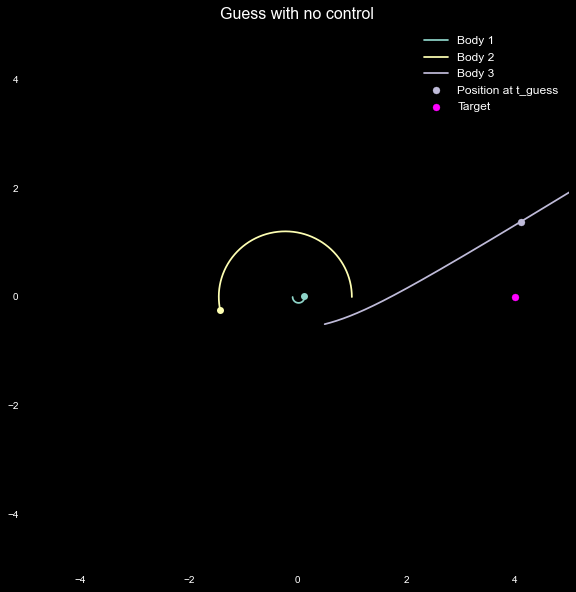

   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          1.18e+00       3.04e+00          100            138      
       2          2.91e-04       1.82e-06          238             0       
Solved in 2 iterations, number of nodes 238. 
Maximum relative residual: 2.91e-04 
Maximum boundary residual: 1.82e-06
t_f = 2.9465334659984115
m_f = 6.173420240839041
x(t_f) =  [4.00340218 0.07955074]


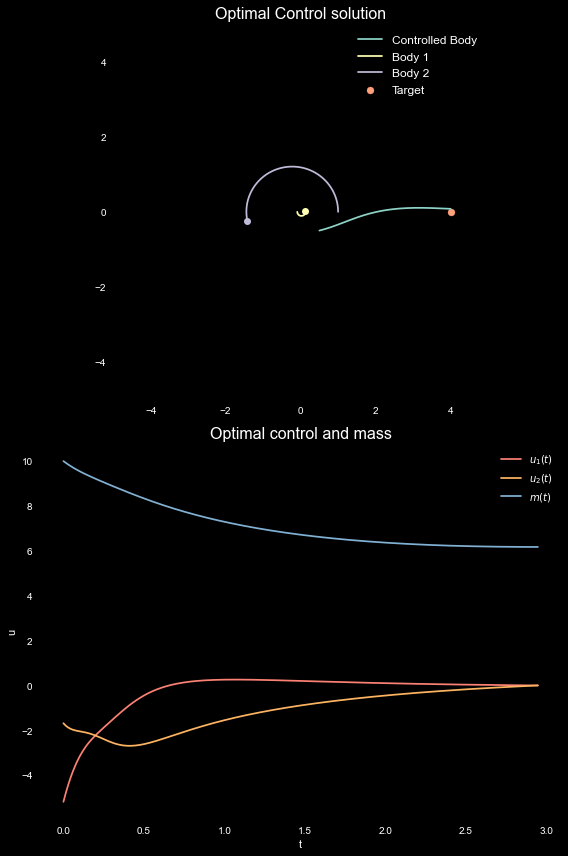

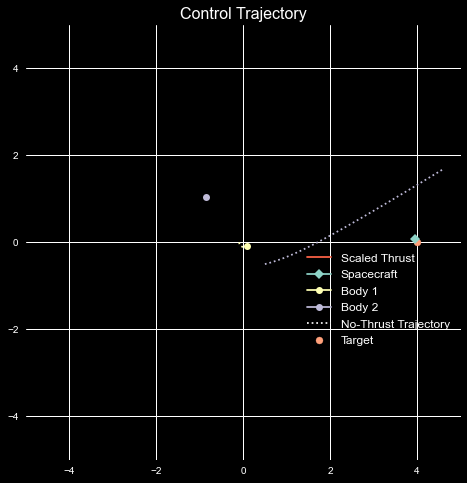

In [5]:
targ = np.array([4, 0])
sol, sol2, u = solar_sys_sol(x0=np.array([.5, -.5]), 
                        v0=np.array([2, .5]), 
                        masses=np.array([1, .09, 0]), 
                        target=targ, 
                        m0=np.array([10]), 
                        t_guess=2.5, 
                        plot_initial=True,
                        verbose=2)

plot_solar_sys_sol(sol, sol2, targ, filename='./../Plots/third_control_attempt')
animate_control(sol, sol2, u, targ, 'Control Trajectory', '/../Animations/third_control_attempt', skip=5, interval=100., lim=(-5,5))

<video src="./../Animations/third_control_attempt.mp4" controls></video>